In [60]:
import pandas as pd
import numpy as np
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [61]:
def get_df(user_file,rating_file):
    user_columns = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
    users = pd.read_csv(user_file, sep='|', names=user_columns,
                        encoding='latin-1')
    ratings_columns = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
    ratings = pd.read_csv(rating_file, sep='\t', names=ratings_columns,
                          encoding='latin-1')
    user_ratings = pd.merge(users,ratings, on='user_id', how='inner')

    user_ratings.drop(['age','sex','occupation','zip_code','unix_timestamp'],axis=1,inplace=True)
    return user_ratings


In [62]:
user_ratings = get_df('ml-100k/u.user','ml-100k/u.data')
user_ratings.head()

,user_id,movie_id,rating
0,1,61,4
1,1,189,3
2,1,33,4
3,1,160,4
4,1,20,4


In [63]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)            

In [64]:
labels = ['1','2','3','4','5']
data = user_ratings['rating'].value_counts().sort_index(ascending=False)
text=[]
for val in (data.values/user_ratings.shape[0]*100):
    
    text.append(val)
fig = go.Figure(data=[go.Pie(labels=labels,values=text,hole=.3)])
fig.show()

In [65]:


data = user_ratings.groupby('movie_id')['rating'].count()


trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = {
                         'start' : 0,
                         'end' : 50,
                         'size' : 2
                     })


fig = go.Figure(data=[trace], layout={
    'title' : 'Distribution of Ratings Per Movie',
    'xaxis' : {'title' : 'Ratings / Movie '},
    'yaxis' : {'title' : 'Count'},
    'bargap' : 0.2
})
iplot(fig)

In [66]:
user_ratings.groupby('movie_id')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,movie_id,rating
49,50,583
257,258,509
99,100,508
180,181,507
293,294,485
285,286,481
287,288,478
0,1,452
299,300,431
120,121,429


In [67]:


data = user_ratings.groupby('user_id')['rating'].count().clip(upper=50)

trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = {
                       'start' : 0,
                       'end' : 50,
                       'size' : 2  
                     })

layout = go.Layout(title = 'Distribution of Ratings Per User',
                   xaxis = {'title' : 'Ratings / User'},
                   yaxis = {'title' : 'Count'},
                   bargap = 0.2)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [68]:
min_movie_ratings = 60
min_user_ratings = 40

movies_cat = user_ratings['movie_id'].value_counts() > min_movie_ratings

movies_cat = movies_cat[movies_cat].index.tolist()

users_cat = user_ratings['user_id'].value_counts() > min_user_ratings
users_cat = users_cat[users_cat].index.tolist()
m_cat = user_ratings['user_id'].isin(users_cat)
user_ratings_new = user_ratings[(user_ratings['movie_id'].isin(movies_cat)) & m_cat]
print('The original data frame: {}'.format(user_ratings.shape))
print('The filtered new data frame: {}'.format(user_ratings_new.shape))

The original data frame: (100000, 3)
The filtered new data frame: (72582, 3)


In [46]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(user_ratings_new[['user_id', 'movie_id', 'rating']], reader)

## SVD++ Implementation

In [47]:
results_benchmarking = []
algorithms = [SVD(),NMF(),KNNWithMeans(),SVDpp(),BaselineOnly(),KNNBasic()]
for test_algo in algorithms:
    results = cross_validate(test_algo,data,measures=['RMSE','MAE'],cv=3,verbose=True)
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    split_data = [str(test_algo).split(' ')[0].split('.')[-1]]
    tmp = tmp.append(pd.Series(split_data, index=['Algorithm']))
    results_benchmarking.append(tmp)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9215  0.9250  0.9161  0.9209  0.0037  
MAE (testset)     0.7239  0.7280  0.7208  0.7242  0.0030  
Fit time          3.82    3.83    3.83    3.83    0.00    
Test time         0.26    0.25    0.35    0.29    0.04    
Evaluating RMSE, MAE of algorithm NMF on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9621  0.9673  0.9689  0.9661  0.0029  
MAE (testset)     0.7713  0.7764  0.7783  0.7753  0.0030  
Fit time          3.73    3.71    3.69    3.71    0.02    
Test time         0.21    0.21    0.30    0.24    0.04    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 3 split(s).

                  Fo

In [48]:
# benchmark
results_benchmarking

[test_rmse    0.920864
 test_mae     0.724225
 fit_time      3.82944
 test_time    0.288781
 Algorithm         SVD
 dtype: object, test_rmse    0.966079
 test_mae      0.77531
 fit_time       3.7086
 test_time    0.241845
 Algorithm         NMF
 dtype: object, test_rmse        0.922725
 test_mae         0.727019
 fit_time         0.205455
 test_time         5.34782
 Algorithm    KNNWithMeans
 dtype: object, test_rmse    0.904558
 test_mae     0.709028
 fit_time      102.724
 test_time     4.02175
 Algorithm       SVDpp
 dtype: object, test_rmse         0.92467
 test_mae         0.730757
 fit_time        0.0876555
 test_time        0.198473
 Algorithm    BaselineOnly
 dtype: object, test_rmse    0.947368
 test_mae     0.747777
 fit_time      0.19506
 test_time     5.17908
 Algorithm    KNNBasic
 dtype: object]

In [49]:
surprise_results = pd.DataFrame(results_benchmarking).set_index('Algorithm').sort_values('test_rmse')

In [50]:
surprise_results


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVDpp,0.904558,0.709028,102.723677,4.021755
SVD,0.920864,0.724225,3.829443,0.288781
KNNWithMeans,0.922725,0.727019,0.205455,5.347816
BaselineOnly,0.924670,0.730757,0.087655,0.198473
KNNBasic,0.947368,0.747777,0.195060,5.179079
NMF,0.966079,0.775310,3.708604,0.241845


In [51]:
algo = SVDpp(n_factors=20,n_epochs=20)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

{'test_rmse': array([0.89650824, 0.90592686, 0.90673962]),
 'fit_time': (101.78808355331421, 101.94788432121277, 102.14864706993103),
 'test_time': (3.8021562099456787, 3.6825084686279297, 3.8147494792938232)}

In [52]:
trainset, testset = train_test_split(data, test_size=0.3)
algo = SVDpp(n_factors=20,n_epochs=20,lr_all=0.007,reg_all=0.02)

In [53]:
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 0.8959


0.8958798395406095

In [54]:
trainset = algo.trainset

In [55]:
def list_from_df(df,col):
    return df[col].tolist()

In [56]:
def get_Iu(uid):
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: 
        return 0
    
def get_Ui(iid):
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [57]:
##
max_ratings_id = df.groupby('iid')['rui'].count().reset_index().sort_values('rui',ascending=False)[:1]
max_ratings_id = list_from_df(max_ratings_id,'iid')[0]

est_pred_df = df[df['iid'] == max_ratings_id]

predicted_ratings = list_from_df(est_pred_df,'est')
actual_ratings = list_from_df(est_pred_df,'rui')
user_ds = list_from_df(est_pred_df,'uid')
user_ds = np.sort(user_ds)

# Plotting
fig = go.Figure()
fig.add_trace(go.Scatter(x=user_ds,y=actual_ratings,
             mode='lines',
             name='Actual'))
fig.add_trace(go.Scatter(x=user_ds,y=predicted_ratings,
             mode='lines',
             name='Predicted'))
fig.show()

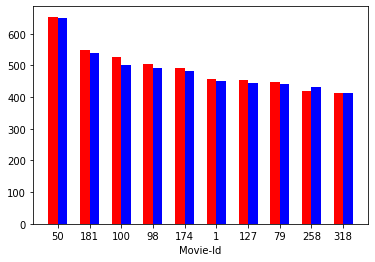

In [58]:
actual_sum_ratings = df.groupby('iid')['rui'].sum().reset_index().sort_values('rui', ascending=False)[:10]
y_movie_id = actual_sum_ratings['iid'].tolist()
actual_sum_ratings = actual_sum_ratings['rui'].tolist()
predicted_sum_ratings = df.groupby('iid')['est'].sum().reset_index().sort_values('est', ascending=False)[:10]
predicted_sum_ratings = predicted_sum_ratings['est'].tolist()

Y = []
for i in y_movie_id:
    Y.append(str(i))
index = np.arange(10)
width = 0.30

plt.bar( index, actual_sum_ratings,width, color ='red',label = 'Actual Rating')
plt.bar( index+width, predicted_sum_ratings,width, color ='blue',label = 'Predicted Rating')
plt.xlabel("Movie-Id")
plt.xticks(index+ width/2,Y)
plt.show();


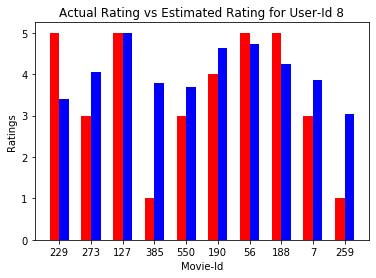

In [59]:
df3 = df[df['uid'] == 8].head(n=10)
movie_id = df3['iid'].tolist()
x = []
for i in movie_id:
    x.append(str(i))
actual_rating= df3['rui'].tolist()
estimated_rating = df3['est'].tolist()
variance = df3['err'].tolist()

index = np.arange(10)
width = 0.30
plt.bar( index, actual_rating,width, color ='red',label = 'Actual Rating')
plt.bar( index+width, estimated_rating,width, color ='blue',label = 'Predicted Rating')
plt.title("Actual Rating vs Estimated Rating for User-Id 8")
plt.xlabel("Movie-Id")
plt.ylabel("Ratings")
plt.xticks(index+ width/2,x)
plt.show();